# Laboratorio 4: Familias de Malware
## Manuel Archila 161250
## Diego Franco 20240

### Parte  1

In [18]:
import os
import pandas as pd
import pefile
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

In [19]:
# Función para extraer características de un archivo PE utilizando pefile
def extract_pe_features(file_path):
    pe_features = {}
    try:
        pe = pefile.PE(file_path)

        # PE Header
        pe_features['Machine'] = pe.FILE_HEADER.Machine
        pe_features['TimeDateStamp'] = pe.FILE_HEADER.TimeDateStamp
        pe_features['NumberOfSections'] = pe.FILE_HEADER.NumberOfSections
        # Agregar más características del PE Header según sea necesario

        # Secciones
        sections = {}
        for section in pe.sections:
            sections[section.Name.decode().strip('\x00')] = section.SizeOfRawData
        pe_features.update(sections)

        # Llamadas a funciones
        imports = {}
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            for imp in entry.imports:
                if imp.name:
                    if imp.name.decode('utf-8') in imports:
                        imports[imp.name.decode('utf-8')] += 1
                    else:
                        imports[imp.name.decode('utf-8')] = 1
        pe_features.update(imports)
    except pefile.PEFormatError as e:
        print(f"Error al analizar el archivo {file_path}: {e}")

    return pe_features

In [20]:
# Directorio donde se encuentran los archivos de malware
malware_dir = "./MALWR"

# Lista para almacenar características de los archivos de malware
malware_features = []

# Recorrer archivos en el directorio de malware y extraer características
for file_name in os.listdir(malware_dir):
    if os.path.isfile(os.path.join(malware_dir, file_name)):
        file_path = os.path.join(malware_dir, file_name)
        features = extract_pe_features(file_path)
        malware_features.append(features)

# Crear DataFrame de pandas con las características
df = pd.DataFrame(malware_features)

# Eliminar características irrelevantes si es necesario
# df = df.drop(columns=['nombre_de_caracteristica_irrelevante'])

# Manejar datos faltantes si es necesario
#df = df.dropna()

# Manejo de datos faltantes
# Si hay valores faltantes en el DataFrame, podemos imputarlos utilizando la media o la mediana de cada columna
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Normalización o estandarización
# Es importante estandarizar las características para que todas tengan la misma escala
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_imputed)
df_scaled = pd.DataFrame(scaled_features, columns=df.columns)



print(df.describe())

Error al analizar el archivo ./MALWR/.DS_Store: 'DOS Header magic not found.'
       Machine  TimeDateStamp  NumberOfSections  UPX0          UPX1  \
count     40.0   4.000000e+01         40.000000  32.0      32.00000   
mean     332.0   1.268479e+09          3.025000   0.0   84576.00000   
std        0.0   3.467763e+07          0.158114   0.0  140827.56047   
min      332.0   1.195430e+09          3.000000   0.0    3584.00000   
25%      332.0   1.242321e+09          3.000000   0.0    4096.00000   
50%      332.0   1.263576e+09          3.000000   0.0    4096.00000   
75%      332.0   1.297723e+09          3.000000   0.0   79744.00000   
max      332.0   1.319016e+09          4.000000   0.0  346112.00000   

             .rsrc  LoadLibraryA  ExitProcess  GetProcAddress  VirtualProtect  \
count    27.000000          32.0         27.0            32.0            32.0   
mean    777.481481           1.0          1.0             1.0             1.0   
std     519.242227           0.0       

Se ha realizado una adaptación para el análisis estático de archivos de malware presentes en un directorio específico. Utilizando la biblioteca pefile, se ha desarrollado una función extract_pe_features que permite extraer características relevantes de archivos PE. Esta función toma como entrada la ruta de un archivo, intenta abrirlo utilizando pefile, y extrae características del PE header, secciones y llamadas a funciones si el archivo es válido. Además, se ha implementado un manejo de errores para capturar posibles excepciones causadas por archivos que no sean archivos PE válidos, lo que garantiza que el análisis continúe para los archivos restantes en el directorio, incluso si algunos archivos no pueden ser procesados.

Una vez obtenido el DataFrame con las características de los archivos de malware, se aplicaron técnicas de preprocesamiento para asegurar que los algoritmos de aprendizaje no supervisado puedan manipular los datos de manera efectiva. Estas técnicas incluyen el manejo de datos faltantes mediante la imputación de valores utilizando la media de cada columna, la normalización o estandarización de características para asegurarse de que todas estén en la misma escala, y la reducción de dimensionalidad utilizando el algoritmo PCA para proyectar las características en un espacio de menor dimensión. Estos pasos de preprocesamiento son fundamentales para preparar los datos de manera adecuada antes de aplicar los algoritmos de aprendizaje no supervisado para el clustering de los archivos de malware.

## Parte 2

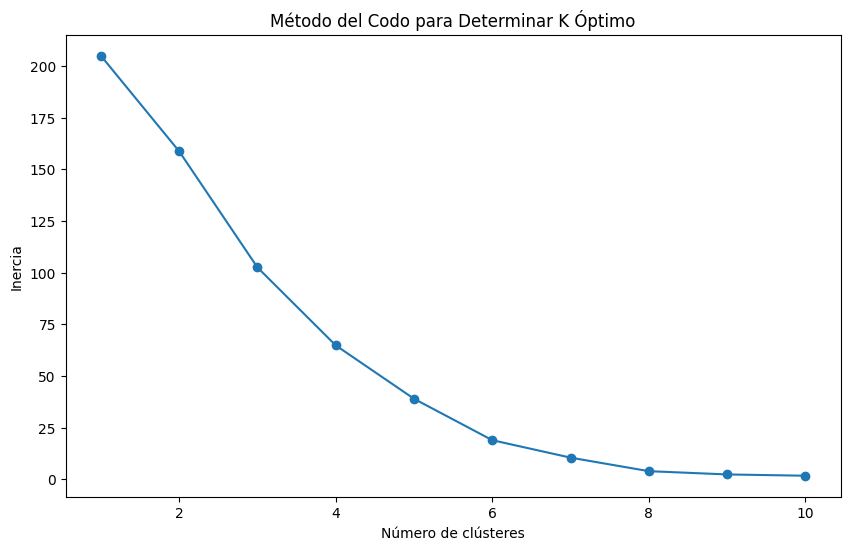

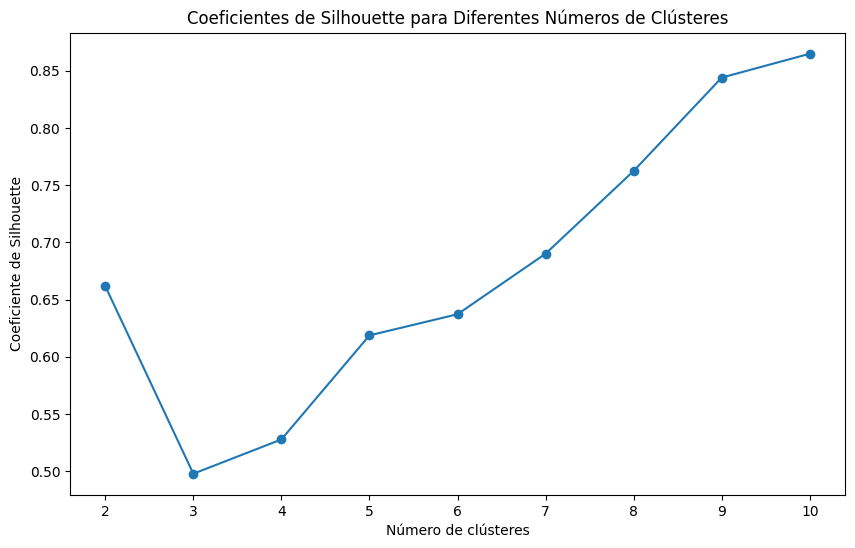

In [21]:
# Método del Codo
k_range = range(1, 11)
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficando la curva del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clústeres')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar K Óptimo')
plt.show()

# Coeficiente de Silhouette
silhouette_scores = []

for k in range(2, 11):  # El coeficiente de Silhouette no se puede calcular para k = 1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Graficando los coeficientes de Silhouette
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de clústeres')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Coeficientes de Silhouette para Diferentes Números de Clústeres')
plt.show()


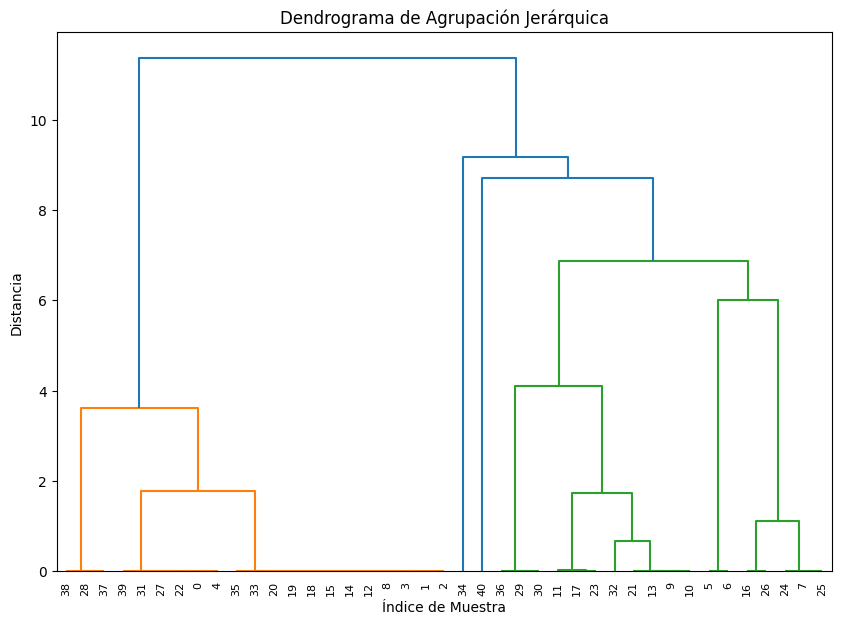

Para max_d = 10, número de clústeres = 2, Coeficiente de Silhouette = 0.4290305704669028
Para max_d = 15, todos los puntos de datos están en un solo clúster.
Para max_d = 20, todos los puntos de datos están en un solo clúster.
Para max_d = 25, todos los puntos de datos están en un solo clúster.
Para maxclust = 2, Coeficiente de Silhouette = 0.4290305704669028
Para maxclust = 3, Coeficiente de Silhouette = 0.4553963989813872
Para maxclust = 4, Coeficiente de Silhouette = 0.48681178613688536
Para maxclust = 5, Coeficiente de Silhouette = 0.5530547291620052


In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# Realizar la agrupación jerárquica
Z = linkage(df_scaled, 'ward')

# Graficar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrograma de Agrupación Jerárquica')
plt.xlabel('Índice de Muestra')
plt.ylabel('Distancia')
plt.show()

# Prueba diferentes valores para 'max_d' o usa 'maxclust' para un número específico de clústeres
# Ejemplo usando 'max_d'
max_d_values = [10, 15, 20, 25]  # Ajusta esta lista basada en tu observación del dendrograma
for max_d in max_d_values:
    clusters = fcluster(Z, max_d, criterion='distance')
    if len(np.unique(clusters)) > 1:  # Asegurarse de que hay más de un clúster
        score = silhouette_score(df_scaled, clusters)
        print(f'Para max_d = {max_d}, número de clústeres = {len(np.unique(clusters))}, Coeficiente de Silhouette = {score}')
    else:
        print(f'Para max_d = {max_d}, todos los puntos de datos están en un solo clúster.')

# Ejemplo usando 'maxclust'
max_clust_values = [2, 3, 4, 5]  # Prueba diferentes números de clústeres
for n_clust in max_clust_values:
    clusters = fcluster(Z, n_clust, criterion='maxclust')
    score = silhouette_score(df_scaled, clusters)
    print(f'Para maxclust = {n_clust}, Coeficiente de Silhouette = {score}')


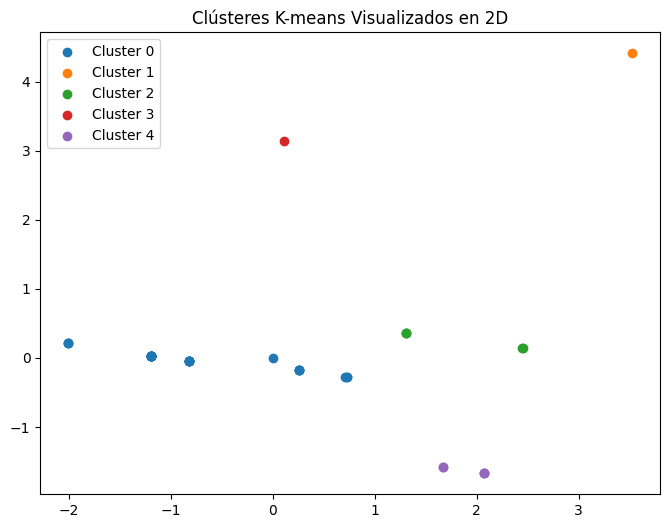

In [23]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Ajuste de K-means con el número óptimo de clústeres (reemplaza 'n_clusters' con el número elegido)
n_clusters = 5  # Cambia este valor según tus resultados del método del codo y el coeficiente de Silhouette
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Reducción de la dimensionalidad para visualización
pca = PCA(n_components=2)  # Reducir a dos dimensiones
reduced_data = pca.fit_transform(df_scaled)

# Visualización de clústeres
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(reduced_data[clusters == i, 0], reduced_data[clusters == i, 1], label=f'Cluster {i}')
plt.title('Clústeres K-means Visualizados en 2D')
plt.legend()
plt.show()


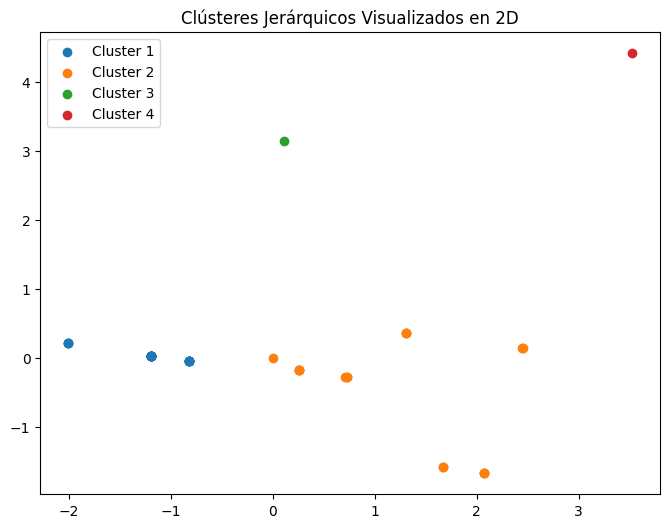

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA

# Agrupación jerárquica
Z = linkage(df_scaled, 'ward')
max_d = 8  # Ajusta este valor basado en tu dendrograma
clusters_hier = fcluster(Z, max_d, criterion='distance')

# Reducción de la dimensionalidad para la visualización
pca = PCA(n_components=2)  # Reducir a dos dimensiones
reduced_data_hier = pca.fit_transform(df_scaled)

# Visualización de clústeres
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(clusters_hier)
for cluster in unique_clusters:
    plt.scatter(reduced_data_hier[clusters_hier == cluster, 0], reduced_data_hier[clusters_hier == cluster, 1], label=f'Cluster {cluster}')
plt.title('Clústeres Jerárquicos Visualizados en 2D')
plt.legend()
plt.show()


En este análisis, comenzamos calculando clústeres utilizando dos métodos de agrupación: K-means y Agrupación Jerárquica. Para K-means, determinamos el número óptimo de clústeres aplicando el método del codo y evaluando el coeficiente de Silhouette, lo cual nos ayudó a identificar un equilibrio entre la compactación de los clústeres y la separación entre ellos. Posteriormente, aplicamos K-means con este número óptimo de clústeres para segmentar los datos en grupos distintos.

De manera similar, para la Agrupación Jerárquica, generamos un dendrograma que nos permitió visualizar cómo los datos podrían agruparse a diferentes niveles de distancia. Al elegir un corte adecuado en el dendrograma, definimos un número apropiado de clústeres y los aplicamos al conjunto de datos.

Después de realizar la agrupación con ambos métodos, procedimos a visualizar los resultados. Dado que la alta dimensionalidad de los datos dificulta la visualización directa, utilizamos PCA (Análisis de Componentes Principales) para reducir la dimensionalidad a dos dimensiones, lo cual facilitó la interpretación visual de los clústeres. Cada punto en las gráficas resultantes representa una observación del conjunto de datos, y se colorea según el clúster asignado. Esto nos permite observar cómo las observaciones se agrupan en el espacio reducido y evaluar la efectividad de los métodos de agrupación utilizados.